# COMP 551 Project 4 Kaggle MNIST

### Ran Cheng, 260768706   |   XXXX, XXXXXXX    |    XXXX, XXXXXXX

### Read Image

In [1]:
%matplotlib inline
# import data
import numpy   as np 
import scipy.misc # to visualize only  
x = np.loadtxt("./Data/train_x.csv", delimiter=",") # load from text 
y = np.loadtxt("./Data/train_y.csv", delimiter=",") 
x = x.reshape(-1, 64, 64) # reshape 
y = y.reshape(-1, 1) 

### Preprocess Image

y[4]:  [8.]


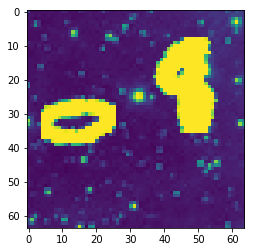

In [3]:
import matplotlib.pyplot as plt
plt.imshow(x[4])
print("y[4]: ", y[4])

### Filter out the background

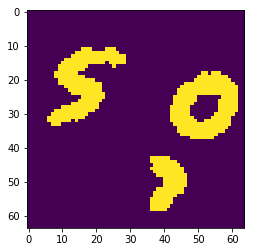

In [31]:
inputImg = x[500]
inputImg[inputImg < 255] = 0
inputImg[inputImg > 0] = 1
plt.imshow(inputImg)

In [35]:
inputImg.shape

(64, 64)

In [34]:
import cv2
import numpy as np

# ret,thresh = cv2.threshold(x[4],254,255,0)
# im_bw = cv2.cvtColor(inputImg, cv2.COLOR_BGR2GRAY)
contours,hierarchy = cv2.findContours(inputImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[0]
M = cv2.moments(cnt)
plt.imshow(M)

error: /io/opencv/modules/imgproc/src/contours.cpp:199: error: (-210) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function cvStartFindContours_Impl


[]

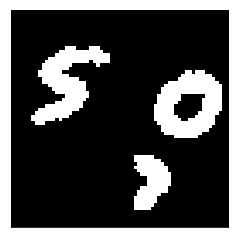

In [44]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure


# Find contours at a constant value of 0.8
contours = measure.find_contours(inputImg, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(inputImg, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

In [62]:
i = 0
max_diff = -100
max_contor = None
max_x_diff = 0
max_y_diff = 0
for contor in contours:
    x_diff = max(contor[:,1]) - min(contor[:,1])
    y_diff = max(contor[:,0]) - min(contor[:,0])
    print('contour[ %d]'%i,  'x_diff: %0.2f' % x_diff, 'y_diff: %0.2f' % y_diff)
    current_diff = max(x_diff, y_diff)
    if current_diff > max_diff:
        max_contor = contours[i]
        max_diff = current_diff
        max_x_diff = x_diff
        max_y_diff = y_diff
    i += 1

contour[ 0] x_diff: 22.40 y_diff: 22.40
contour[ 1] x_diff: 19.40 y_diff: 19.40
contour[ 2] x_diff: 9.60 y_diff: 8.60
contour[ 3] x_diff: 10.40 y_diff: 15.40


AttributeError: 'Figure' object has no attribute 'add_patch'

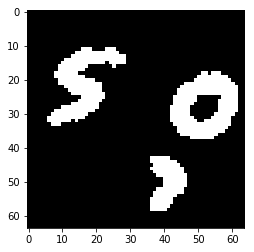

In [66]:
import matplotlib.patches as patches
plt.imshow(inputImg, interpolation='nearest', cmap=plt.cm.gray)
box_x_s = min(max_contor[:,1])
box_x_e = max(max_contor[:,1])
box_y_s = min(max_contor[:,0])
box_y_e = max(max_contor[:,0])
rect = patches.Rectangle((box_x_s,box_y_s),max_x_diff,max_y_diff,linewidth=1,edgecolor='r',facecolor='none')
plt.figure().add_patch(rect)

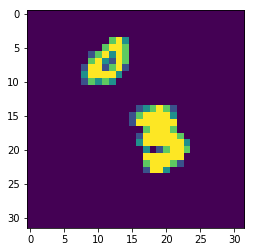

In [21]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

image_rescaled = rescale(inputImg, 1.0 / 2.0, mode='wrap')
plt.imshow(image_rescaled)

In [3]:
#split data to train and test
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x/255, y, test_size=0.15, random_state=42)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [4]:
# normalize all the pixel values to [0,1]
X_train[0]

array([[0.        , 0.00784314, 0.05490196, ..., 0.22745098, 0.25098039,
        0.28235294],
       [0.        , 0.00784314, 0.05882353, ..., 0.22745098, 0.25098039,
        0.28235294],
       [0.        , 0.01568627, 0.05882353, ..., 0.22745098, 0.25490196,
        0.28235294],
       ...,
       [0.6745098 , 0.69411765, 0.69411765, ..., 0.03529412, 0.05098039,
        0.07843137],
       [0.6745098 , 0.69411765, 0.69803922, ..., 0.02745098, 0.05098039,
        0.0627451 ],
       [0.66666667, 0.68235294, 0.69803922, ..., 0.00784314, 0.03529412,
        0.07058824]])

### 1. Start With Baseline, Linear SVM

In [5]:
from sklearn import datasets, svm, metrics

############### Classification with grid search ##############
# If you don't want to wait, comment this section and uncommnet section below with
# standalone SVM classifier

# Create parameters grid for RBF kernel, we have to set C and gamma
from sklearn.model_selection import GridSearchCV
# generate matrix with all gammas
# [ [10^-4, 2*10^-4, 5*10^-4], 
#   [10^-3, 2*10^-3, 5*10^-3],
#   ......
#   [10^3, 2*10^3, 5*10^3] ]
#gamma_range = np.outer(np.logspace(-4, 3, 8),np.array([1,2, 5]))
gamma_range = np.outer(np.logspace(-3, 0, 4),np.array([1,5]))
gamma_range = gamma_range.flatten()

# generate matrix with all C
#C_range = np.outer(np.logspace(-3, 3, 7),np.array([1,2, 5]))
C_range = np.outer(np.logspace(-1, 1, 3),np.array([1,5]))
# flatten matrix, change to 1D numpy array
C_range = C_range.flatten()

parameters = {'kernel':['rbf'], 'C':C_range, 'gamma': gamma_range}

In [6]:
# reshape X data to 2d for linear fitting
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [7]:
X_train.shape

(42500, 4096)

In [8]:
def plot_param_space_scores(scores, C_range, gamma_range):
    """
    Draw heatmap of the validation accuracy as a function of gamma and C
    
    
    Parameters
    ----------
    scores - 2D numpy array with accuracies
    
    """
    #
    # The score are encoded as colors with the hot colormap which varies from dark
    # red to bright yellow. As the most interesting scores are all located in the
    # 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
    # as to make it easier to visualize the small variations of score values in the
    # interesting range while not brutally collapsing all the low score values to
    # the same color.

    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.jet,
               norm=MidpointNormalize(vmin=0.5, midpoint=0.9))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title('Validation accuracy')  

In [9]:
import time
import datetime as dt

In [ ]:

svm_clsf = svm.SVC()
grid_clsf = GridSearchCV(estimator=svm_clsf,param_grid=parameters,n_jobs=1, verbose=2)


start_time = dt.datetime.now()
print('Start param searching at {}'.format(str(start_time)))

grid_clsf.fit(X_train, y_train)

elapsed_time= dt.datetime.now() - start_time
print('Elapsed time, param searching {}'.format(str(elapsed_time)))
sorted(grid_clsf.cv_results_.keys())

classifier = grid_clsf.best_estimator_
params = grid_clsf.best_params_



scores = grid_clsf.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

plot_param_space_scores(scores, C_range, gamma_range)


######################### end grid section #############

Start param searching at 2018-03-05 02:43:09.396471
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] gamma=0.001, kernel=rbf, C=0.1 ..................................
[CV] .................. gamma=0.001, kernel=rbf, C=0.1, total=170.5min
[CV] gamma=0.001, kernel=rbf, C=0.1 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 243.7min remaining:    0.0s


[CV] .................. gamma=0.001, kernel=rbf, C=0.1, total=171.3min
[CV] gamma=0.001, kernel=rbf, C=0.1 ..................................


In [ ]:
################ Classifier with good params ###########
# Create a classifier: a support vector classifier

param_C = 5
param_gamma = 0.05
classifier = svm.SVC(C=param_C,gamma=param_gamma)

# We learn the digits on train part
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))
classifier.fit(X_train, y_train)
end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

########################################################

Start learning at 2018-03-05 14:16:10.453655


## Q2 Feed Forward NN with BP

In [23]:
# the progress meter widget
from tqdm import tqdm
import numpy 
import math
import scipy.special

# define the Feed Forward NN:
class NeuralNetwork:
    # initialization
    # dims -> dimenison of the neural network architecture: [64*64 100 10] This is one hidden layer with 100 HU.
    # alpha -> learning rate
    # decay -> l1 weight decay
    # activation_func -> activation function //!!! maybe better to use LeRU for each layer ****TODO******
    # activation_func_prime -> differential activation function
    def __init__(self, dims, alpha, decay, activation_func, activation_func_prime):
        self.layers = [] # contain all layers of neurons.
        # hidden layer:
        for i in range(1, len(dims)):
            # hidden layer weight list for each hidden layer
            hiddenlayer_weights = []
            # for each layer, and each neuron, they contains the last layer's weight combination
            # the number of weight that the current neuron pocessessed is equal to the last layer's number:
            for j in range(dims[i]):
                # unifying the weight distribution between [-1,1]
                hiddenlayer_weights.append(numpy.random.uniform(-1, 1, dims[i - 1]))
            hiddenlayer_weights = numpy.array(hiddenlayer_weights)
        self.layers.append((hiddenlayer_weights))
        self.alpha = alpha
        self.weight_decay = decay
        self.f = activation_func
        self.f_prime = activation_func_prime
        
    # feed forward
    def feedForward(self, inputs):
        # loop through the layers and produce the output from the production of last layer
        # inputs and the current neurons' weight lists
        layer_outputs = []
        # loop layers of weights:
        for i in range(len(self.layers)):
            if i == 0:
                # first layer should be the input layer
                current_output = self.f(numpy.dot(self.layers[i], inputs))
            else:
                # other layer's input should be the last layer's output
                current_output = self.f(numpy.dot(self.layers[i], layer_outputs[i-1]))
            current_output = numpy.array(current_output)
            layer_outputs.append(current_output)
        return layer_outputs
        
    # back propogation
    def backPropagation(self, inputs, targets):
        # implement the BP:
        # for each layer we adjust the weight list according to the error function
        # conversion of inputs and target arrays to transposed numpy matrixes
        inputs = numpy.transpose(numpy.array([numpy.array(inputs)]))
        targets = numpy.transpose(numpy.array([numpy.array(targets)]))
        # outputs of each layer, we need all the layer's data to perform BP
        outputs = self.feedForward(inputs)
        # get error from the last layer output and target
        outErr = targets - outputs[len(outputs) - 1]
        # initialize hidden layer errors for each HU
        HiddenErrs = [None] * (len(outputs) - 1)
        # loop backward to update the previous layer's error
        for i in reversed(range(len(outputs) - 1)):
            HiddenErr = 0
            if i == len(outputs) - 2:
                # from the output error
                hiddenErr = numpy.dot(numpy.transpose(self.layers[i + 1]), outErr)
            else:
                # from 'back' layer
                hiddenErr = numpy.dot(numpy.transpose(self.layers[i + 1]), hiddenErrs[i + 1])
            HiddenErrs[i] = hiddenErr
        # update the weights using l1 weight decay
        for i in reversed(range(len(self.layers))):
            if i == len(self.layers) - 1:
                self.layers[i] += (self.alpha * numpy.dot((outErr * self.f_prime(outputs[i])), numpy.transpose(outputs[i - 1]))) + (self.alpha * self.weight_decay * self.layers[i])
            elif i == 0:
                self.layers[i] += (self.alpha * numpy.dot((HiddenErrs[i] * self.f_prime(outputs[i])), numpy.transpose(inputs))) + (self.alpha * self.weight_decay * self.layers[i])
            else:
                self.layers[i] += (self.alpha * numpy.dot((HiddenErrs[i] * self.f_prime(outputs[i])), numpy.transpose(outputs[i - 1]))) + (self.alpha * self.weight_decay * self.layers[i])

    # train
    def train(self, inputs, targets):
        self.backPropagation(inputs, targets)
        
    def query(self, inputs):
        inputs = numpy.transpose(numpy.array([numpy.array(inputs)]))
        return self.feedForward(inputs)[-1]

In [27]:
# test of the neural network
nn = NeuralNetwork([2, 2, 1], 0.01, 0.001, lambda x: scipy.special.expit(x), lambda x: x * (1 - x))
for i in tqdm(range(100000)):
    nn.train([0, 0], [0])
    nn.train([0, 1], [0])
    nn.train([1, 1], [1])
    nn.train([1, 0], [0])
    nn.train([1, 1], [1])

print(nn.query([0, 1]))
print(nn.query([1, 1]))
print(nn.query([1, 0]))
print(nn.query([0, 0]))


100%|██████████| 100000/100000 [00:10<00:00, 9198.86it/s]

[[0.]]
[[0.]]
[[0.]]
[[0.5]]
